In [76]:
import random, time
import numpy as np
from collections import defaultdict
import operator
import matplotlib.pyplot as plt

## Misc functions and utilities

In [77]:
orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)

In [78]:
def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))

In [79]:
def turn_heading(heading, inc, headings=orientations):
    return headings[(headings.index(heading) + inc) % len(headings)]


def turn_right(heading):
    return turn_heading(heading, RIGHT)

def turn_left(heading):
    return turn_heading(heading, LEFT)

def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return math.hypot((xA - xB), (yA - yB))

In [80]:
def isnumber(x):
    """Is x a number?"""
    return hasattr(x, '__int__')

### Function to generate grid data (list of lists) with arbitrary size and complexity for the grid world

In [81]:
def gen_mdp(nrows=3,ncols=4,terminals = [(3,2),(3,1)],main_reward = -0.04,
            terminal_rewards = [1,-1],block_coords = [(1,1)]):
    """
    Generates a list of list to feed to the main GridMDP class from simple user API
    nrows: Number of rows
    ncols: Number of columns
    terminals: Coordinates of terminal points, list of tuples
    main_reward: The default reward for traversing the grid world
    block_coords: Coordinates of solid blocks, list of tules
    """
    
    x = [[main_reward] * ncols for i in range(nrows)]
    for i,t in enumerate(terminals):
        x[t[1]][t[0]]=terminal_rewards[i]
    for b in block_coords:
        x[b[1]][b[0]]=None
    x.reverse()
       
    return x

## Class definitions

### Base MDP class

In [82]:
class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state."""

    def __init__(self, init, actlist, terminals, transitions = {}, reward = None, states=None, gamma=.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        if states:
            self.states = states
        else:
            ## collect states from transitions table
            self.states = self.get_states_from_transitions(transitions)
            
        
        self.init = init
        
        if isinstance(actlist, list):
            ## if actlist is a list, all states have the same actions
            self.actlist = actlist
        elif isinstance(actlist, dict):
            ## if actlist is a dict, different actions for each state
            self.actlist = actlist
        
        self.terminals = terminals
        self.transitions = transitions
        if self.transitions == {}:
            print("Warning: Transition table is empty.")
        self.gamma = gamma
        if reward:
            self.reward = reward
        else:
            self.reward = {s : 0 for s in self.states}
        #self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        if(self.transitions == {}):
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set([tr[1] for actions in transitions.values() 
                              for effects in actions.values() for tr in effects])
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):
        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)
        # check that init is a valid state
        assert self.init in self.states
        # check reward for each state
        #assert set(self.reward.keys()) == set(self.states)
        assert set(self.reward.keys()) == set(self.states)
        # check that all terminals are valid states
        assert all([t in self.states for t in self.terminals])
        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

### Transition matrix, init, termianls, rewards

In [83]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

### Custom MDP subclass

In [84]:
class CustomMDP(MDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        MDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.t[state][action]

In [85]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=.9)

In [86]:
our_mdp.actions('A')

['X', 'Y']

### Grid MDP

In [87]:
class GridMDP(MDP):

    """A two-dimensional grid MDP, as in [Figure 17.1]. All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state). Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x] is not None:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
        MDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions = transitions, 
                     reward = reward, states = states, gamma=gamma)

    def calculate_T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
    
    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return self.transitions[state][action]
 
    def go(self, state, direction):
        """Return the state that results from going in this direction."""
        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""
        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {
            (1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})

### Grid example

![grid-mdp](https://raw.githubusercontent.com/aimacode/aima-python/c16bb8bdc28e8f9fcc6e7f76a92b9492bf019d87/images/grid_mdp.jpg)

In [88]:
grid_rewards = [[-0.04, -0.04, -0.04, +1],
        [-0.04, None,  -0.04, -1],
        [-0.04, -0.04, -0.04, -0.04]]

In [89]:
grid_terminals = [(3, 2), (3, 1)]

In [90]:
grid_1= GridMDP(grid_rewards,grid_terminals,gamma=0.95)

In [91]:
grid_1.states

{(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2)}

In [92]:
grid_1.actions((1,2))

[(1, 0), (0, 1), (-1, 0), (0, -1)]

In [93]:
grid_rewards_big = [[-0.04, -0.04, -0.04, -0.04, -0.04],
        [None, -0.04, None, -0.04, 1],
        [-0.04, -0.04, -0.04, -0.04, -1],
        [-0.04, -0.04, -0.04, None, -0.04],
        [-0.04, -0.04, -0.04, -0.04, -0.04]]

In [94]:
grid_terminals_big = [(3,1),(4,1)]

In [95]:
grid_2=GridMDP(grid_rewards_big,grid_terminals_big)

In [96]:
grid_2.grid

[[-0.04, -0.04, -0.04, -0.04, -0.04],
 [-0.04, -0.04, -0.04, None, -0.04],
 [-0.04, -0.04, -0.04, -0.04, -1],
 [None, -0.04, None, -0.04, 1],
 [-0.04, -0.04, -0.04, -0.04, -0.04]]

In [97]:
grid_1.grid

[[-0.04, -0.04, -0.04, -0.04],
 [-0.04, None, -0.04, -1],
 [-0.04, -0.04, -0.04, 1]]

## Value iteration

### Value iteration function

In [98]:
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration.
    mdp: The MDP object
    epsilon: Stopping criteria
    """
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if delta < epsilon * (1 - gamma) / gamma:
            return U

### Value iteration visualization

In [99]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

In [100]:
columns = 4
rows = 3
U_over_time = value_iteration_instru(grid_1)

In [101]:
def make_plot_grid_step_function(columns, rows, U_over_time):
    """ipywidgets interactive function supports single parameter as input.
    This function creates and return such a function by taking as input
    other parameters."""

    def plot_grid_step(iteration):
        data = U_over_time[iteration]
        data = defaultdict(lambda: 0, data)
        grid = []
        for row in range(rows):
            current_row = []
            for column in range(columns):
                current_row.append(data[(column, row)])
            grid.append(current_row)
        grid.reverse() # output like book
        fig = plt.figure(figsize=(rows,columns))
        fig = plt.imshow(grid, cmap=plt.cm.bwr, interpolation='nearest')

        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

        for col in range(len(grid)):
            for row in range(len(grid[0])):
                magic = grid[col][row]
                fig.axes.text(row, col, "{0:.2f}".format(magic), va='center', ha='center')

        plt.show()

    return plot_grid_step

In [102]:
def make_visualize(slider):
    """Takes an input a sliderand returns callback function
    for timer and animation."""

    def visualize_callback(Visualize, time_step):
        if Visualize is True:
            for i in range(slider.min, slider.max + 1):
                slider.value = i
                time.sleep(float(time_step))

    return visualize_callback

In [103]:
plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

In [104]:
import ipywidgets as widgets
from IPython.display import display

iteration_slider = widgets.IntSlider(min=1, max=15, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=1, description='iteration', max=15, min=1), Output()), _dom_classes=('widget-interact',))

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Delay:', options=('0', '0.1', '0.2', '0.5', '0.7', '1.0'), value='0'), Output()), _dom_classes=('widget-interact',))

### Value iteration for a larger Grid World
Let us use the `gen_mdp` function to generate a large (10x10) and more complex grid world and run value iteration on it and visualize!

In [160]:
large_grid = gen_mdp(nrows=10,ncols=10,terminals=[(6, 3), (5, 2),(4,4)],main_reward=-0.23,
                     terminal_rewards=[3,-3,-5],block_coords=[(1,1),(2,3),(7,5),(8,2)])

In [162]:
large_gridworld = GridMDP(large_grid,terminals=[(6, 3), (5, 2),(4,4)])

In [165]:
large_gridworld.grid

[[-0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23],
 [-0.23, None, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23],
 [-0.23, -0.23, -0.23, -0.23, -0.23, -3, -0.23, -0.23, None, -0.23],
 [-0.23, -0.23, None, -0.23, -0.23, -0.23, 3, -0.23, -0.23, -0.23],
 [-0.23, -0.23, -0.23, -0.23, -5, -0.23, -0.23, -0.23, -0.23, -0.23],
 [-0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, None, -0.23, -0.23],
 [-0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23],
 [-0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23],
 [-0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23],
 [-0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23, -0.23]]

In [167]:
np.array(large_gridworld.grid).shape

(10, 10)

In [173]:
columns = 10
rows = 10
U_over_time = value_iteration_instru(large_gridworld,iterations=100)

In [174]:
plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

In [175]:
iteration_slider = widgets.IntSlider(min=1, max=95, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=1, description='iteration', max=95, min=1), Output()), _dom_classes=('widget-interact',))

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Delay:', options=('0', '0.1', '0.2', '0.5', '0.7', '1.0'), value='0'), Output()), _dom_classes=('widget-interact',))

## Policy Iteration

In [105]:
def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""
    return sum([p * U[s1] for (p, s1) in mdp.T(s, a)])

In [195]:
def policy_evaluation(pi, U, mdp, k=20):
    """Returns an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""
    
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum([p * U[s1] for (p, s1) in T(s, pi[s])])
    return U

In [196]:
def policy_iteration(mdp):
    """Solves an MDP by policy iteration [Figure 17.7]"""
    
    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return pi

In [108]:
policy_iteration(grid_1)

{(0, 0): (0, 1),
 (0, 1): (0, 1),
 (0, 2): (1, 0),
 (1, 0): (-1, 0),
 (1, 2): (1, 0),
 (2, 0): (0, 1),
 (2, 1): (0, 1),
 (2, 2): (1, 0),
 (3, 0): (-1, 0),
 (3, 1): None,
 (3, 2): None}

In [186]:
policy_iteration(large_gridworld)

{(0, 0): (1, 0),
 (0, 1): (0, 1),
 (0, 2): (1, 0),
 (0, 3): (1, 0),
 (0, 4): (1, 0),
 (0, 5): (1, 0),
 (0, 6): (1, 0),
 (0, 7): (1, 0),
 (0, 8): (1, 0),
 (0, 9): (1, 0),
 (1, 0): (1, 0),
 (1, 2): (1, 0),
 (1, 3): (0, -1),
 (1, 4): (1, 0),
 (1, 5): (1, 0),
 (1, 6): (1, 0),
 (1, 7): (1, 0),
 (1, 8): (1, 0),
 (1, 9): (1, 0),
 (2, 0): (1, 0),
 (2, 1): (1, 0),
 (2, 2): (1, 0),
 (2, 4): (0, 1),
 (2, 5): (1, 0),
 (2, 6): (1, 0),
 (2, 7): (1, 0),
 (2, 8): (1, 0),
 (2, 9): (1, 0),
 (3, 0): (1, 0),
 (3, 1): (1, 0),
 (3, 2): (0, 1),
 (3, 3): (1, 0),
 (3, 4): (0, -1),
 (3, 5): (1, 0),
 (3, 6): (1, 0),
 (3, 7): (1, 0),
 (3, 8): (1, 0),
 (3, 9): (1, 0),
 (4, 0): (1, 0),
 (4, 1): (1, 0),
 (4, 2): (0, 1),
 (4, 3): (1, 0),
 (4, 4): None,
 (4, 5): (1, 0),
 (4, 6): (1, 0),
 (4, 7): (1, 0),
 (4, 8): (0, -1),
 (4, 9): (1, 0),
 (5, 0): (1, 0),
 (5, 1): (1, 0),
 (5, 2): None,
 (5, 3): (1, 0),
 (5, 4): (1, 0),
 (5, 5): (1, 0),
 (5, 6): (0, -1),
 (5, 7): (0, -1),
 (5, 8): (0, -1),
 (5, 9): (0, -1),
 (6, 0): (0

In [187]:
def print_table(table, header=None, sep='   ', numfmt='{}'):
    """Print a list of lists as a table, so that columns line up nicely.
    header, if specified, will be printed as the first row.
    numfmt is the format for all numbers; you might want e.g. '{:.2f}'.
    (If you want different formats in different columns,
    don't use print_table.) sep is the separator between columns."""
    justs = ['rjust' if isnumber(x) else 'ljust' for x in table[0]]

    if header:
        table.insert(0, header)

    table = [[numfmt.format(x) if isnumber(x) else x for x in row]
             for row in table]

    sizes = list(
        map(lambda seq: max(map(len, seq)),
            list(zip(*[map(str, row) for row in table]))))

    for row in table:
        print(sep.join(getattr(str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))

In [197]:
def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action."""

    pi = {}
    for s in mdp.states:
        pi[s] = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi

In [189]:
pi1 = best_policy(grid_1, value_iteration(grid_1, .001))

In [190]:
pi1

{(0, 0): (0, 1),
 (0, 1): (0, 1),
 (0, 2): (1, 0),
 (1, 0): (-1, 0),
 (1, 2): (1, 0),
 (2, 0): (0, 1),
 (2, 1): (0, 1),
 (2, 2): (1, 0),
 (3, 0): (-1, 0),
 (3, 1): None,
 (3, 2): None}

In [191]:
print_table(grid_1.to_arrows(pi1))

>   >      >   .
^   None   ^   .
^   <      ^   <


In [192]:
pi2 = best_policy(large_gridworld, value_iteration(large_gridworld, .001))

In [194]:
print_table(large_gridworld.to_arrows(pi2))

>   >      >      >   >   v   v   v      v      v
>   >      >      >   v   v   v   v      v      v
>   >      >      >   >   v   v   v      v      v
>   >      >      >   >   v   v   <      v      v
>   >      >      >   >   >   v   None   v      v
>   >      ^      v   .   >   v   <      <      <
>   v      None   >   >   >   .   <      <      <
>   >      >      ^   ^   .   ^   ^      None   ^
^   None   >      >   >   >   ^   ^      <      ^
>   >      >      >   >   >   ^   ^      <      <


## Q-learning

### Q-learning class

In [118]:
class QLearningAgent:
    """ An exploratory Q-learning agent. It avoids having to learn the transition
        model because the Q-value of a state can be related directly to those of
        its neighbors.
    """
    def __init__(self, mdp, Ne, Rplus, alpha=None):

        self.gamma = mdp.gamma
        self.terminals = mdp.terminals
        self.all_act = mdp.actlist
        self.Ne = Ne  # iteration limit in exploration function
        self.Rplus = Rplus  # large value to assign before iteration limit
        self.Q = defaultdict(float)
        self.Nsa = defaultdict(float)
        self.s = None
        self.a = None
        self.r = None

        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1./(1+n)

    def f(self, u, n):
        """ Exploration function. Returns fixed Rplus until
        agent has visited state, action a Ne number of times."""
        if n < self.Ne:
            return self.Rplus
        else:
            return u

    def actions_in_state(self, state):
        """ Return actions possible in given state.
            Useful for max and argmax. """
        if state in self.terminals:
            return [None]
        else:
            return self.all_act

    def __call__(self, percept):
        s1, r1 = self.update_state(percept)
        Q, Nsa, s, a, r = self.Q, self.Nsa, self.s, self.a, self.r
        alpha, gamma, terminals = self.alpha, self.gamma, self.terminals,
        actions_in_state = self.actions_in_state

        if s in terminals:
            Q[s, None] = r1
        if s is not None:
            Nsa[s, a] += 1
            Q[s, a] += alpha(Nsa[s, a]) * (r + gamma * max(Q[s1, a1]
                                           for a1 in actions_in_state(s1)) - Q[s, a])
        if s in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.r = s1, r1
            self.a = max(actions_in_state(s1), key=lambda a1: self.f(Q[s1, a1], Nsa[s1, a1]))
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept

### Trial run function

In [119]:
def run_single_trial(agent_program, mdp):
    """Execute trial for given agent_program
    and mdp."""

    def take_single_action(mdp, s, a):
        """
        Select outcome of taking action a
        in state s. Weighted Sampling.
        """
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in mdp.T(s, a):
            probability, state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        return state

    current_state = mdp.init
    while True:
        current_reward = mdp.R(current_state)
        percept = (current_state, current_reward)
        next_action = agent_program(percept)
        if next_action is None:
            break
        current_state = take_single_action(mdp, current_state, next_action)

### Testing Q-learning

In [120]:
# Define an agent
q_agent = QLearningAgent(grid_1, Ne=10, Rplus=2,alpha=lambda n: 60./(59+n))

#### A single trial run

In [121]:
run_single_trial(q_agent,grid_1)

#### The utility values are close to default rewards

In [122]:
q_agent.Q

defaultdict(float,
            {((0, 0), (-1, 0)): 0.0,
             ((0, 0), (0, -1)): 0.0,
             ((0, 0), (0, 1)): 0.0,
             ((0, 0), (1, 0)): -0.04,
             ((1, 0), (-1, 0)): 0.0,
             ((1, 0), (0, -1)): 0.0,
             ((1, 0), (0, 1)): 0.0,
             ((1, 0), (1, 0)): -0.04,
             ((2, 0), (-1, 0)): 0.0,
             ((2, 0), (0, -1)): 0.0,
             ((2, 0), (0, 1)): 0.0,
             ((2, 0), (1, 0)): -0.04,
             ((3, 0), (-1, 0)): 0.0,
             ((3, 0), (0, -1)): 0.0,
             ((3, 0), (0, 1)): 0.0,
             ((3, 0), (1, 0)): -0.04,
             ((3, 1), None): 0.0})

#### Run for 200 iterations

In [123]:
for i in range(200):
    run_single_trial(q_agent,grid_1)

#### Q-values looking somewhat improved

In [124]:
q_agent.Q

defaultdict(float,
            {((0, 0), (-1, 0)): -0.10243920315740275,
             ((0, 0), (0, -1)): -0.09819715018613952,
             ((0, 0), (0, 1)): 0.2382472880371105,
             ((0, 0), (1, 0)): -0.11861518897773643,
             ((0, 1), (-1, 0)): -0.09734192810904108,
             ((0, 1), (0, -1)): -0.09909299850141175,
             ((0, 1), (0, 1)): 0.2941889969753578,
             ((0, 1), (1, 0)): -0.07257142857142856,
             ((0, 2), (-1, 0)): -0.06831207589733931,
             ((0, 2), (0, -1)): -0.07121023376591129,
             ((0, 2), (0, 1)): -0.06831207589966465,
             ((0, 2), (1, 0)): 0.3405898772925784,
             ((1, 0), (-1, 0)): -0.10948615738992892,
             ((1, 0), (0, -1)): -0.10784680160592379,
             ((1, 0), (0, 1)): -0.10330782874342406,
             ((1, 0), (1, 0)): 0.47577410193315944,
             ((1, 2), (-1, 0)): 0.3073437556344969,
             ((1, 2), (0, -1)): 0.35594915887835576,
             ((1, 2), (0, 1

#### Checking how a particular state's utility evolves over iteration

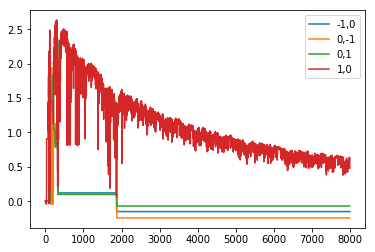

In [125]:
x1=[]
x2=[]
x3=[]
x4=[]

q_agent = QLearningAgent(grid_1, Ne=40, Rplus=1.5,alpha=lambda n: 5000./(4999+n))
for i in range(8000):
    run_single_trial(q_agent,grid_1)
    x1.append(q_agent.Q[((2,2),(-1,0))])
    x2.append(q_agent.Q[((2,2),(0,-1))])
    x3.append(q_agent.Q[((2,2),(0,1))])
    x4.append(q_agent.Q[((2,2),(1,0))])

plt.plot(x1)
plt.plot(x2)
plt.plot(x3)
plt.plot(x4)
plt.legend(['-1,0','0,-1','0,1','1,0'])
plt.show()

### Function to convert the Q Values above into U estimates.

In [126]:
def get_U_from_Q(q_agent):
    U = defaultdict(lambda: -100.) # Large negative value for comparison
    for state_action, value in q_agent.Q.items():
        state, action = state_action
        if U[state] < value:
                    U[state] = value
    return U

In [127]:
get_U_from_Q(q_agent)

defaultdict(<function __main__.get_U_from_Q.<locals>.<lambda>>,
            {(0, 0): 0.30682800400961163,
             (0, 1): 0.3860527954573418,
             (0, 2): 0.4493309459371817,
             (1, 0): 0.21970662257748597,
             (1, 2): 0.3873121574419675,
             (2, 0): 0.03584576794755143,
             (2, 1): -0.0497265964135455,
             (2, 2): 0.48097567000717234,
             (3, 0): 0.0,
             (3, 1): 0.08471372691977053,
             (3, 2): 0.7073544026768809})

### Running Q-learning over a long period and comparing to value iteration method

In [128]:
q_agent = QLearningAgent(grid_1, Ne=25, Rplus=1.5,alpha=lambda n: 10000./(9999+n))
qhistory=[]
for i in range(10000):
    run_single_trial(q_agent,grid_1)
    U=get_U_from_Q(q_agent)
    qhistory.append(U)
print(get_U_from_Q(q_agent))

defaultdict(<function get_U_from_Q.<locals>.<lambda> at 0x00000194C46CED90>, {(0, 0): -0.17390119774672366, (1, 0): -0.2457858844955896, (2, 0): 1.0100946680551934, (3, 0): -0.4833365869091763, (3, 1): 0.832836980918857, (0, 1): -0.15062584705269844, (0, 2): -0.14680715977032222, (1, 2): -0.10954308641870227, (2, 2): 0.03154053912543155, (3, 2): 0.5456556618736108, (2, 1): -0.3235031662894632})


In [129]:
print(value_iteration(grid_1,epsilon=0.001))

{(0, 1): 0.5574828451603404, (1, 2): 0.7531405483223766, (3, 2): 1.0, (0, 0): 0.464516644753505, (3, 0): 0.22957996193922584, (3, 1): -1.0, (2, 1): 0.5691092225518013, (2, 0): 0.45103488646335127, (2, 2): 0.8553208559957037, (1, 0): 0.38642617706646115, (0, 2): 0.6467925974571826}


### Function for utility estimate by Q-learning by many iterations

In [130]:
def qlearning_iter(agent_program,mdp,iterations=1000,print_final_utility=True):
    """
    Function for utility estimate by Q-learning by many iterations
    Returns a history object i.e. a list of dictionaries, where utility estimate for each iteration is stored
    
    q_agent = QLearningAgent(grid_1, Ne=25, Rplus=1.5,
                            alpha=lambda n: 10000./(9999+n))
    hist=qlearning_iter(q_agent,grid_1,iterations=10000)
    
    """
    qhistory=[]
    
    for i in range(iterations):
        run_single_trial(agent_program,mdp)
        U=get_U_from_Q(agent_program)
        if len(U)==len(mdp.states):
            qhistory.append(U)
    
    if print_final_utility:
        print(U)
    return qhistory

In [199]:
# Define a Q-learning agent
q_agent = QLearningAgent(grid_1, Ne=25, Rplus=1.5,alpha=lambda n: 10000./(9999+n))
# Run 10000 iterations to get a history
hist=qlearning_iter(q_agent,grid_1,iterations=10000)

defaultdict(<function get_U_from_Q.<locals>.<lambda> at 0x00000194C5FDAEA0>, {(0, 0): 0.5085226982197011, (1, 0): 0.3100565054424438, (2, 0): 0.24990414771238256, (3, 0): -0.5631325888949164, (3, 1): -0.9012498523245246, (2, 1): 0.3639049809108597, (2, 2): 0.8917923000614533, (3, 2): 0.9803634777977597, (0, 1): 0.6038769029356321, (0, 2): 0.7111665137520491, (1, 2): 0.7840143793180178})


### How do the long-term utility estimates with Q-learning compare with value iteration?

In [204]:
def plot_qlearning_vi(hist, vi,plot_n_states=None):
    """
    Compares and plots a Q-learning and value iteration results for the utility estimate of an MDP's states
    hist: A history object from a Q-learning run
    vi: A value iteration estimate for the same MDP
    plot_n_states: Restrict the plotting for n states (randomly chosen)
    """
    
    utilities={k:[] for k in list(vi.keys())}
    for h in hist:
        for state in h.keys():
            utilities[state].append(h[state])
    
    if plot_n_states==None:
        for state in list(vi.keys()):
            plt.figure(figsize=(7,4))
            plt.title("Plot of State: {} over Q-learning iterations".format(str(state)),fontsize=16)
            plt.plot(utilities[state])
            plt.hlines(y=vi[state],xmin=0,xmax=1.1*len(hist))
            plt.legend(['Q-learning estimates','Value iteration estimate'],fontsize=14)
            plt.xlabel("Iterations",fontsize=14)
            plt.ylabel("Utility of the state",fontsize=14)
            plt.grid(True)
            plt.show()
    else:
        for state in list(vi.keys())[:plot_n_states]:
            plt.figure(figsize=(7,4))
            plt.title("Plot of State: {} over Q-learning iterations".format(str(state)),fontsize=16)
            plt.plot(utilities[state])
            plt.hlines(y=vi[state],xmin=0,xmax=1.1*len(hist))
            plt.legend(['Q-learning estimates','Value iteration estimate'],fontsize=14)
            plt.xlabel("Iterations",fontsize=14)
            plt.ylabel("Utility of the state",fontsize=14)
            plt.grid(True)
            plt.show()

### Testing the long-term utility learning for the small (default) grid world

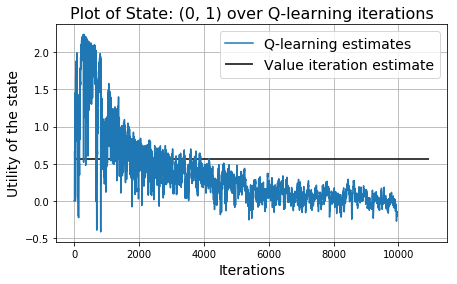

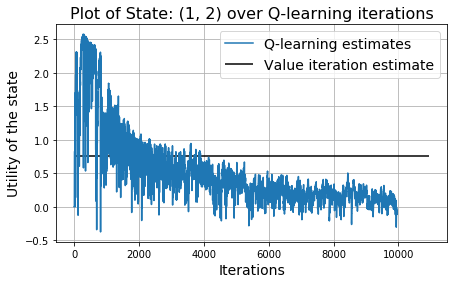

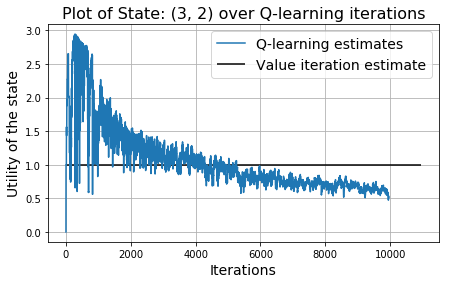

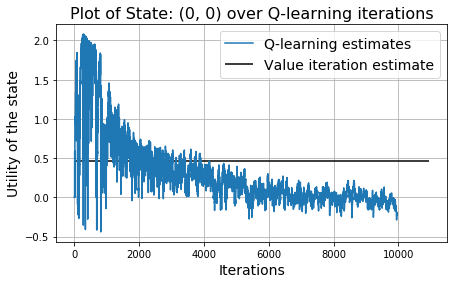

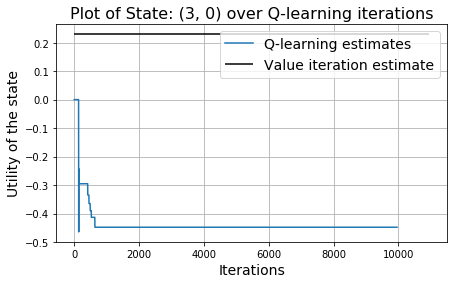

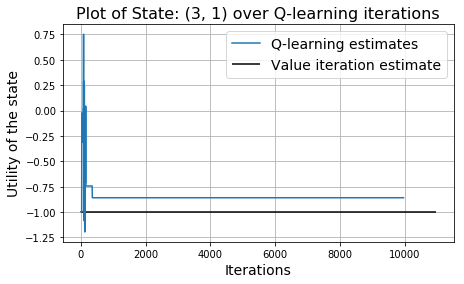

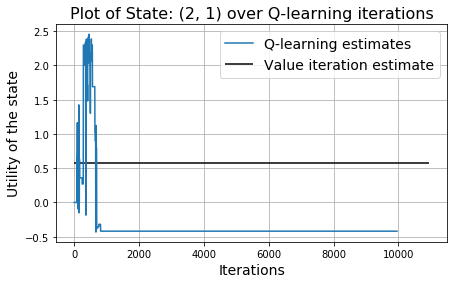

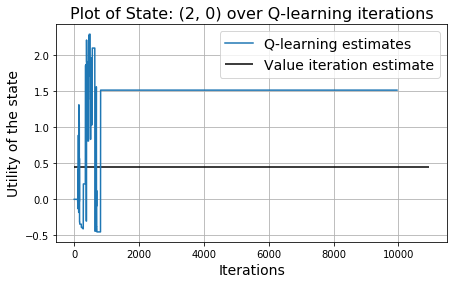

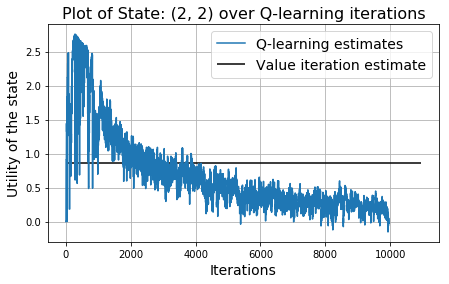

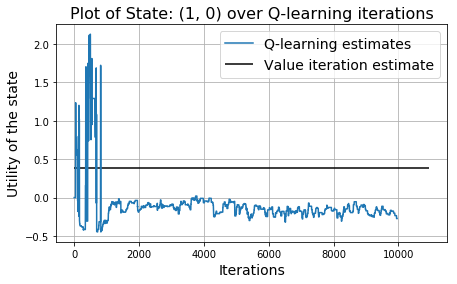

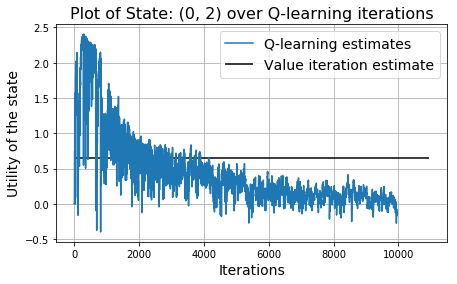

In [205]:
# Define the Q-learning agent
q_agent = QLearningAgent(grid_1, Ne=25, Rplus=1.5,alpha=lambda n: 10000./(9999+n))
# Obtain the history by running the Q-learning for many iterations
hist=qlearning_iter(q_agent,grid_1,iterations=10000,print_final_utility=False)
# Get a value iteration estimate using the same MDP
vi = value_iteration(grid_1,epsilon=0.001)
# Compare the utility estimates from two methods
plot_qlearning_vi(hist,vi)

### Testing the long-term utility learning for the large grid world

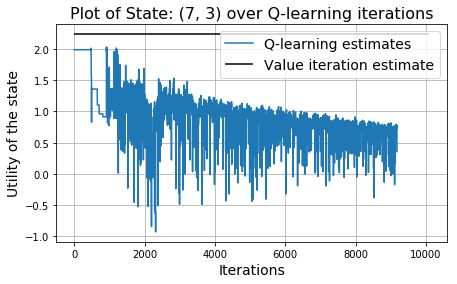

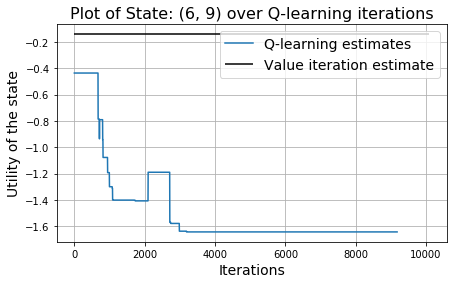

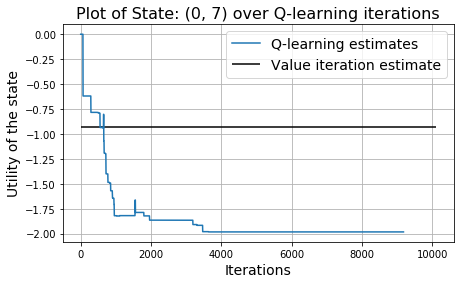

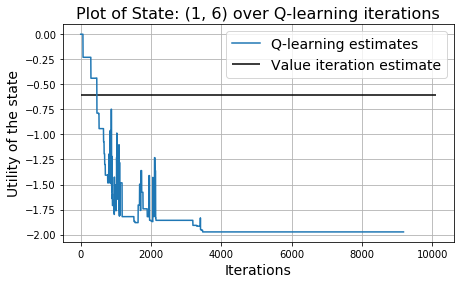

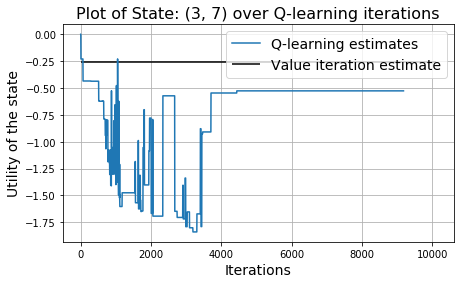

In [211]:
# Define the Q-learning agent
q_agent = QLearningAgent(large_gridworld, Ne=100, Rplus=5,alpha=lambda n: 10000./(9999+n))
# Obtain the history by running the Q-learning for many iterations
hist=qlearning_iter(q_agent,large_gridworld,iterations=10000,print_final_utility=False)
# Get a value iteration estimate using the same MDP
vi = value_iteration(large_gridworld,epsilon=0.001)
# Compare the utility estimates from two methods (plot only 5 states)
plot_qlearning_vi(hist,vi,plot_n_states=5)